In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
animes = pd.read_csv('anime_dataset.csv')

In [15]:
print(len(animes.synopsis))

19311


In [7]:
genres = animes.iloc[0]['genre'].replace("'", ",").replace("[", "").replace("]", "").replace(", ", "").split(',,')
genres = set([x.replace(",", "") for x in genres])
for i in range(1, len(animes)):
    g = animes.iloc[i]['genre'].replace("'", ",").replace("[", "").replace("]", "").replace(", ", "").split(',,')
    g = [x.replace(",", "") for x in g]
    genres = genres.union(set(g))
genres.remove('')

In [8]:
print('Number of genres are', len(genres))

Number of genres are 43


In [9]:
def delete_reference(text):
    new_text = text
    if '[Written ' in new_text:
        new_text,_,_ = new_text.partition('[Written')
    if '(Source:' in text:
        new_text,_,_ = new_text.partition('(Source:')
    return new_text

In [10]:
animes.synopsis[1005]

'In 19th-century London, class lines are sharply drawn, and the social standing to which people are born dictates the path their lives will follow. Emma, an honest and hardworking young maid, never felt her place in life to be a burden. But then she met William, a member of the gentry and the eldest son of a wealthy family. His warm smile and earnest affection threaten to capture her heart... but can love truly conquer all? \r\n \r\n(Source: RightStuf)'

In [11]:
data = animes[animes['synopsis'].notna()]
synopsis = data.synopsis

synopsis = synopsis.apply(lambda x: delete_reference(x))

rx = re.compile('[&#/@`)(;<=\'"$%>]')
synopsis = synopsis.apply(lambda x: rx.sub('',x))
synopsis = synopsis.apply(lambda x: x.replace('>',""))
synopsis = synopsis.apply(lambda x: x.replace('`',""))
synopsis = synopsis.apply(lambda x: x.replace(')',""))
synopsis = synopsis.apply(lambda x: x.replace('(',""))
synopsis = synopsis.apply(lambda x: x.replace('[',""))
synopsis = synopsis.apply(lambda x: x.replace(']',""))
    
synopsis.reset_index(drop=True)

max length 2730
min length 1


(array([3.828e+03, 2.729e+03, 1.863e+03, 1.845e+03, 1.544e+03, 1.240e+03,
        1.082e+03, 8.100e+02, 7.110e+02, 7.140e+02, 6.730e+02, 5.060e+02,
        3.220e+02, 2.060e+02, 1.080e+02, 4.500e+01, 4.200e+01, 1.500e+01,
        1.800e+01, 8.000e+00, 6.000e+00, 5.000e+00, 4.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 1.000e+00]),
 array([1.00000000e+00, 9.19666667e+01, 1.82933333e+02, 2.73900000e+02,
        3.64866667e+02, 4.55833333e+02, 5.46800000e+02, 6.37766667e+02,
        7.28733333e+02, 8.19700000e+02, 9.10666667e+02, 1.00163333e+03,
        1.09260000e+03, 1.18356667e+03, 1.27453333e+03, 1.36550000e+03,
        1.45646667e+03, 1.54743333e+03, 1.63840000e+03, 1.72936667e+03,
        1.82033333e+03, 1.91130000e+03, 2.00226667e+03, 2.09323333e+03,
        2.18420000e+03, 2.27516667e+03, 2.36613333e+03, 2.45710000e+03,
        2.54806667e+03, 2.63903333e+03, 2.73000000e+03]),
 <a list of 30 Patch objects>)

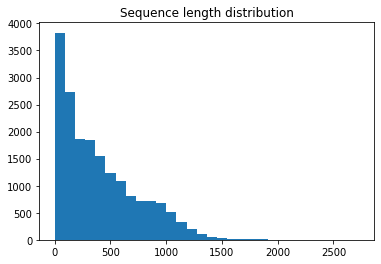

In [13]:
max_length = max(map(len, synopsis))
min_length = min(map(len, synopsis))
print("max length", max_length)
print("min length", min_length)

plt.title('Sequence length distribution')
plt.hist(list(map(len, synopsis)), bins=30)

### LSTM

In [17]:
data = pd.read_csv('anime_dataset.csv',index_col=0)
synopsis = data.synopsis

In [21]:
def clean_description(data):
    
    data = data[data['synopsis'].notna()]
    synopsis = data.synopsis
    
    synopsis = synopsis.apply(lambda x: delete_reference(x))
    synopsis = synopsis.apply(lambda x: x if ((len(str(x).strip().split())<=400) and len(str(x).strip().split())>30  ) else -1)
    synopsis = synopsis[synopsis!=-1]
    
    rx = re.compile('[&#/@`)(;<=\'"$%>]')
    synopsis = synopsis.apply(lambda x: rx.sub('',x))
    synopsis = synopsis.apply(lambda x: x.replace('>',""))
    synopsis = synopsis.apply(lambda x: x.replace('`',""))
    synopsis = synopsis.apply(lambda x: x.replace(')',""))
    synopsis = synopsis.apply(lambda x: x.replace('(',""))
    synopsis = synopsis.apply(lambda x: x.replace('[',""))
    synopsis = synopsis.apply(lambda x: x.replace(']',""))
    
    return synopsis.reset_index(drop=True)

In [22]:
class config:    
    tokenizer = nltk.word_tokenize    
    batch_size = 32
    seq_len = 30
    emb_dim = 100
    epochs = 15
    hidden_dim = 512
    model_path = 'lstm.bin'

In [23]:
def create_dataset(synopsis,batch_size,seq_len):
    np.random.seed(0)
    synopsis = synopsis.apply(lambda x: str(x).lower()).values
    synopsis_text = ' '.join(synopsis)
    
    
    tokens = config.tokenizer(synopsis_text)
    global num_batches
    num_batches = int(len(tokens)/(seq_len*batch_size))
    tokens = tokens[:num_batches*batch_size*seq_len]
    
    words = sorted(set(tokens))        
    w2i = {w:i for i,w in enumerate(words)}
    i2w = {i:w for i,w in enumerate(words)}
    
    tokens = [w2i[tok] for tok in tokens]
    target = np.zeros_like((tokens))
    target[:-1] = tokens[1:]
    target[-1] = tokens[0]
    
    input_tok = np.reshape(tokens,(batch_size,-1))
    target_tok = np.reshape(target,(batch_size,-1))
    
    print(input_tok.shape)
    print(target_tok.shape)
    
    vocab_size = len(i2w)
    return input_tok,target_tok,vocab_size,w2i,i2w

def create_batches(input_tok,target_tok,batch_size,seq_len):
    
    num_batches = np.prod(input_tok.shape)//(batch_size*seq_len)
    
    for i in range(0,num_batches*seq_len,seq_len):
        yield input_tok[:,i:i+seq_len], target_tok[:,i:i+seq_len]

In [24]:
class LSTM(nn.Module):    
    def __init__(self,hid_dim,emb_dim,vocab_size,num_layers=1):
        super(LSTM,self).__init__()
        self.hid_dim = hid_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size+1
        self.embedding = nn.Embedding(self.vocab_size,self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim,self.hid_dim,batch_first = True,num_layers = self.num_layers)
        self.drop = nn.Dropout(0.3)
        self.linear = nn.Linear(self.hid_dim,vocab_size) 
        
    def forward(self,x,prev_hid):
        x = self.embedding(x)
        x,hid = self.lstm(x,prev_hid)
        x = self.drop(x)
        x = self.linear(x)
        return x,hid
    
    def zero_state(self,batch_size):
        return (torch.zeros(self.num_layers,batch_size,self.hid_dim),torch.zeros(self.num_layers,batch_size,self.hid_dim))

In [25]:
class Loss:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def loss_fn(predicted,target):
    loss = nn.CrossEntropyLoss()
    return loss(predicted,target)

In [27]:
def train(model,device,dataloader,optimizer):
    model.train()
    tk0 = tqdm(dataloader,position=0,leave=True,total = num_batches)
    train_loss = Loss()  
    hid_state,cell_state = model.zero_state(config.batch_size)
    hid_state = hid_state.to(device)
    cell_state = cell_state.to(device)
    losses = []
    for inp,target in tk0:
                
        inp = torch.tensor(inp,dtype=torch.long).to(device)
        target = torch.tensor(target,dtype=torch.long).to(device)

        optimizer.zero_grad()        
        pred,(hid_state,cell_state) = model(inp,(hid_state,cell_state))
        
        loss = loss_fn(pred.transpose(1,2),target)
        
        hid_state = hid_state.detach()
        cell_state = cell_state.detach()
        
        loss.backward()

        _ = torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=2)
        optimizer.step()
        
        train_loss.update(loss.detach().item())
        tk0.set_postfix(loss = train_loss.avg)
        losses.append(loss.detach().item())
    return np.mean(losses)

In [29]:
cleaned_synopsis = clean_description(data)

In [32]:
input_tok,target_tok,vocab_size,w2i,i2w = create_dataset(cleaned_synopsis,batch_size=config.batch_size,seq_len=config.seq_len)

(32, 32220)
(32, 32220)


In [33]:
def run():
    device = 'cuda'
    model = LSTM(vocab_size=vocab_size,emb_dim=config.emb_dim,hid_dim=config.hidden_dim,num_layers=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode = 'min', patience=2, verbose=True, factor=0.5)
    epochs = config.epochs
    
    best_loss = 1000
    for i in range(1,epochs+1):
        train_dataloader = create_batches(batch_size=config.batch_size,input_tok=input_tok,seq_len=config.seq_len,target_tok=target_tok)
        print('Epoch..',i)
        loss = train(model,device,train_dataloader,optimizer)
        if loss<best_loss:
            best_loss = loss
            torch.save(model.state_dict(),config.model_path)
        scheduler.step(loss)
        torch.cuda.empty_cache()
    return model

In [36]:
model = run()

  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 1


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 2


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 3


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 4


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch     4: reducing learning rate of group 0 to 5.0000e-04.
Epoch.. 5


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 6


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 7


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 8


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 9


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 10


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 11


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 12


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 13


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 14


  0%|          | 0/1074 [00:00<?, ?it/s]

Epoch.. 15


100%|██████████| 1074/1074 [06:05<00:00,  2.94it/s, loss=5.19]


In [37]:
def generate_text(model,input_text,device,top_k=5,length = 100):
    output = ''
    model.eval()
    tokens = config.tokenizer(input_text)
        
    h,c = model.zero_state(1)
    h = h.to(device)
    c = c.to(device)
    
    for t in tokens:
        output = output+t+' '
        pred,(h,c) = model(torch.tensor(w2i[t.lower()]).view(1,-1).to(device),(h,c))

    for i in range(length):
        _,top_ix = torch.topk(pred[0],k = top_k)
               
        choices = top_ix[0].tolist()                
        choice = np.random.choice(choices)
        out = i2w[choice]
        output = output + out + ' '
        pred,(h,c) 

In [38]:
device = 'cpu'
mod = LSTM(emb_dim=config.emb_dim,hid_dim=config.hidden_dim,vocab_size=vocab_size,num_layers=3).to(device)
mod.load_state_dict(torch.load(config.model_path))

<All keys matched successfully>

In [41]:
print(generate_text(model = mod, input_text = 'People believe', top_k = 30, length = 100, device = device))

People believe that people have these problems. And if I really do nothing. Because she never has to overcome Jusuke's limits to have a home without it in the world. In the hospital, she builds him himself with the help of the devil and the slaughter. A member and an idol team who can do anything, but they enter his world. If it's left, I won't wait any longer!


### Transformers

In [14]:
!pip install transformers

     |████████████████████████████████| 2.3MB 4.3MB/s 
     |████████████████████████████████| 3.3MB 39.5MB/s 
     |████████████████████████████████| 901kB 38.7MB/s 


In [2]:
import transformers
from transformers import AdamW 
from transformers import get_linear_schedule_with_warmup
import torch
import csv

In [4]:
batch_size = 10
model_path = "gpt2.bin"
max_seq_len = 300
epochs = 5
data_path = 'anime_dataset.csv'
tokenizer = transformers.GPT2Tokenizer.from_pretrained('gpt2')
model = transformers.GPT2LMHeadModel.from_pretrained('gpt2')

In [6]:
class AnimeDataset():
    def __init__(self,data):
        self.eos_tok = '<|endoftext|>'
        synopsis = clean_description(data)
        synopsis = synopsis.apply(lambda x: str(x) + self.eos_tok)
        self.synopsis = synopsis.tolist()
        self.pad_tok = tokenizer.encode(['<|pad|>'])
    def __getitem__(self,item):
        synopsis = self.synopsis[item]
        tokens = tokenizer.encode(synopsis)
        mask = [1]*len(tokens)
        
        max_len = max_seq_len
        if max_len>len(tokens):
            padding_len = max_len - len(tokens)
            tokens = tokens + self.pad_tok*padding_len
            mask = mask + [0]*padding_len
        else:
            tokens = tokens[:max_len]
            mask = mask[:max_len]
        
        if tokens[-1]!= tokenizer.encode(self.eos_tok)[0]:
            tokens[-1] = tokenizer.encode(self.eos_tok)[0]
        
        return {'ids':torch.tensor(tokens,dtype = torch.long),
                'mask': torch.tensor(mask,dtype = torch.long),
                'og_synpsis':synopsis}
         
     
    def __len__(self):
        return len(self.synopsis)

In [7]:
def train(model,dataloader,optimizer,scheduler,device):
    model.train()
    tk0 = tqdm(dataloader, total = len(dataloader), leave = True, position = 0)
    train_loss = Loss()
    losses = []
    for bi,d in enumerate(tk0):
            
        ids = d['ids'].to(device,dtype = torch.long)
        mask = d['mask'].to(device,dtype = torch.long)
        
        loss,out = model(input_ids = ids, labels = ids, attention_mask  = mask)[:2]
        
        train_loss.update(loss.item())    
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        scheduler.step()
        model.zero_grad()
        tk0.set_postfix(loss = train_loss.avg)
    return np.mean(losses)

In [8]:
def run():
    data = pd.read_csv(data_path, quoting=csv.QUOTE_NONE, comment='#', error_bad_lines=False)
    dataset = AnimeDataset(data = data)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
    
    device = 'cuda'
    model.to(device)
    
    optimizer = AdamW(model.parameters(),lr = 0.0001,weight_decay = 0.003)    
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=10,num_training_steps = int(len(data)/batch_size * epochs))
    
    best_loss = 100000
    for epoch in range(epochs):
        loss = train(model,dataloader,optimizer,scheduler,device)
        if loss<best_loss:
            best_loss = loss
            torch.save(model.state_dict(),model_path)
        torch.cuda.empty_cache

In [9]:
run()

b'Skipping line 4: expected 64 fields, saw 69\nSkipping line 8: expected 64 fields, saw 66\nSkipping line 10: expected 64 fields, saw 67\nSkipping line 11: expected 64 fields, saw 65\nSkipping line 14: expected 64 fields, saw 68\nSkipping line 15: expected 64 fields, saw 67\nSkipping line 16: expected 64 fields, saw 68\nSkipping line 17: expected 64 fields, saw 69\nSkipping line 19: expected 64 fields, saw 65\nSkipping line 23: expected 64 fields, saw 69\nSkipping line 24: expected 64 fields, saw 65\nSkipping line 26: expected 64 fields, saw 67\nSkipping line 27: expected 64 fields, saw 66\nSkipping line 28: expected 64 fields, saw 71\nSkipping line 32: expected 64 fields, saw 65\nSkipping line 34: expected 64 fields, saw 70\nSkipping line 41: expected 64 fields, saw 69\nSkipping line 48: expected 64 fields, saw 65\nSkipping line 49: expected 64 fields, saw 66\nSkipping line 52: expected 64 fields, saw 67\nSkipping line 53: expected 64 fields, saw 73\nSkipping line 54: expected 64 fiel

In [10]:
def generate_text(input_text,device = 'cuda',max_len = 300):
  pad_tok = tokenizer.encode(['<|pad|>'])[0]
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  input_ids = tokenizer.encode(input_text)
  mask = [1]*len(input_ids)

  padding_len = max_seq_len - len(input_ids)
  
  input_ids = input_ids 
  mask = mask + [0]*padding_len

  ids = torch.tensor(input_ids,dtype = torch.long).to(device).unsqueeze(0)
  mask = torch.tensor(mask,dtype = torch.long).to(device).unsqueeze(0)
  
  sample_out = model.generate(ids, min_length = 30,max_length=max_len, pad_token_id=pad_tok,
                              top_p=0.85, early_stopping=True, do_sample=True, num_beams = 5, no_repeat_ngram_size = 2,num_return_sequences=1)
  
  print(tokenizer.decode(sample_out[0],skip_special_tokens = True))

In [25]:
generate_text('After a long time',device = 'cuda')

Generated Text:

 After a long time, he decides to become a master swordsman in his own right. He is able to use his skills to protect his friends and protect them from the forces of evil.
